In [107]:
"""
Dynamic Routing Between Capsules: https://arxiv.org/abs/1710.09829

Author: Riccardo Renzulli
University: Università degli Studi di Torino, Department of Computer Science
"""

import os
import torch
import logging
import json
import argparse
import torch.nn.functional as F
import numpy as np
import ops.utils as utils
import matplotlib.pyplot as plt
from matplotlib import gridspec
from dataloaders.load_data import get_dataloader
from models.vectorCapsNet import VectorCapsNet


In [120]:
CONFIG_FILE = "../results/mnist/VectorCapsNet/capsnet/42/params.json"
CHECKPOINT = "../results/mnist/VectorCapsNet/capsnet/42/checkpoints/model_best_epoch_108.pt"

In [121]:
config = utils.DotDict(json.load(open(CONFIG_FILE)))
config.batch_size = 20

# Enable GPU usage
if config.use_cuda & torch.cuda.is_available():
    device = torch.device(config.cuda_device)
else:
    device = torch.device("cpu")

_, _, test_loader = get_dataloader(config)

if os.path.isfile(CHECKPOINT):
    logging.info("Loading checkpoint '{}'".format(CHECKPOINT))
    checkpoint = torch.load(CHECKPOINT)
    config.num_routing_iterations = checkpoint["routing_iterations"]
    config.epoch = str(checkpoint["epoch"])
    model = VectorCapsNet(config, device)
    model.load_state_dict(checkpoint["state_dict"])
    logging.info("Loaded checkpoint '{}'".format(CHECKPOINT))
else:
    raise Exception("No checkpoint found at '{}'".format(CHECKPOINT))

model.to(device)
model.eval()

# Print the model architecture and parameters
utils.summary(model, config)
logging.info("Number of routing iterations:'{}'".format(config.num_routing_iterations))

# Assume that we are on a CUDA machine, then this should print a CUDA device:
logging.info("Device: {}".format(device))

# First batch of images
dataiter = iter(test_loader)
dataiter.next()
images, labels = dataiter.next()

# Transform to one-hot indices: [batch_size, config.num_classes]
target = F.one_hot(labels, config.num_classes)

# Use GPU if available
images, target = images.to(device), labels.to(device)

# Get class caps and reconstructions
class_caps_poses, class_caps_activations, _, reconstructions = model(images)
reconstructions = reconstructions.view(-1, images.size(1), images.size(2), images.size(3))

# Get predictions
norms = torch.sqrt(torch.sum(class_caps_poses ** 2, dim=2))
# pred: [batch_size,]
pred = norms.max(1, keepdim=True)[1].type(torch.LongTensor).view(config.batch_size)

# Print labels and predictions
lab = torch.cat((labels, pred), 0)
lab = lab.view(2, config.batch_size)

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


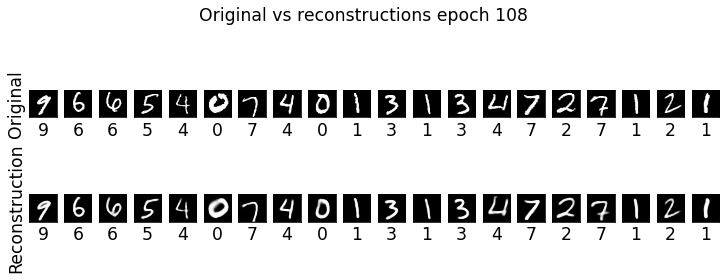

In [125]:
# Show what the individual dimensions of a capsule represent
class_caps_shape = class_caps_poses.size(-2), class_caps_poses.size(-1)
index = 1 #8, 14, -1
example_caps = class_caps_poses[index].unsqueeze(0) # example_caps: [1, 10, 16]
label_caps = target[index] # label_caps: [1, 10]
activations = class_caps_activations[index, :].view(-1, config.num_classes)
perturb_reconstructions = []
perturb_range = np.linspace(start=-0.25, stop=0.25, num=11)

nrow = class_caps_shape[0] * class_caps_shape[1]
ncol = perturb_range.size
for dim in range(nrow):
    for perturb in perturb_range:
        example_caps_perturbed = example_caps.clone()
        example_caps_perturbed[:, :, dim] += perturb
        perturb_rec = model.decoder(example_caps_perturbed, activations)
        perturb_rec = perturb_rec.view(images.size(1), images.size(2), images.size(3))
        perturb_rec = perturb_rec.squeeze()
        perturb_reconstructions.append(perturb_rec.squeeze())

# Show original images vs reconstructions
fig, axs = plt.subplots(2, config.batch_size, figsize=(10, 4))
fig.suptitle("Original vs reconstructions epoch " + config.epoch, fontsize="xx-large")
axs[0, 0].set_ylabel("Original", fontsize="xx-large")
axs[1, 0].set_ylabel("Reconstruction", fontsize="xx-large")

np_images = images.squeeze().cpu().detach().numpy()
np_reconstructions = reconstructions.squeeze().cpu().detach().numpy()

data = [np_images, np_reconstructions]

for i in range(2):
    for j in range(config.batch_size):
        axs[i, j].imshow(data[i][j], cmap=config.cmap)
        axs[i, j].set_yticks([])
        axs[i, j].set_xticks([])
        axs[i, j].set_xlabel(str(lab[i, j].item()), fontsize="xx-large")
plt.tight_layout(pad=0.4)
plt.show()

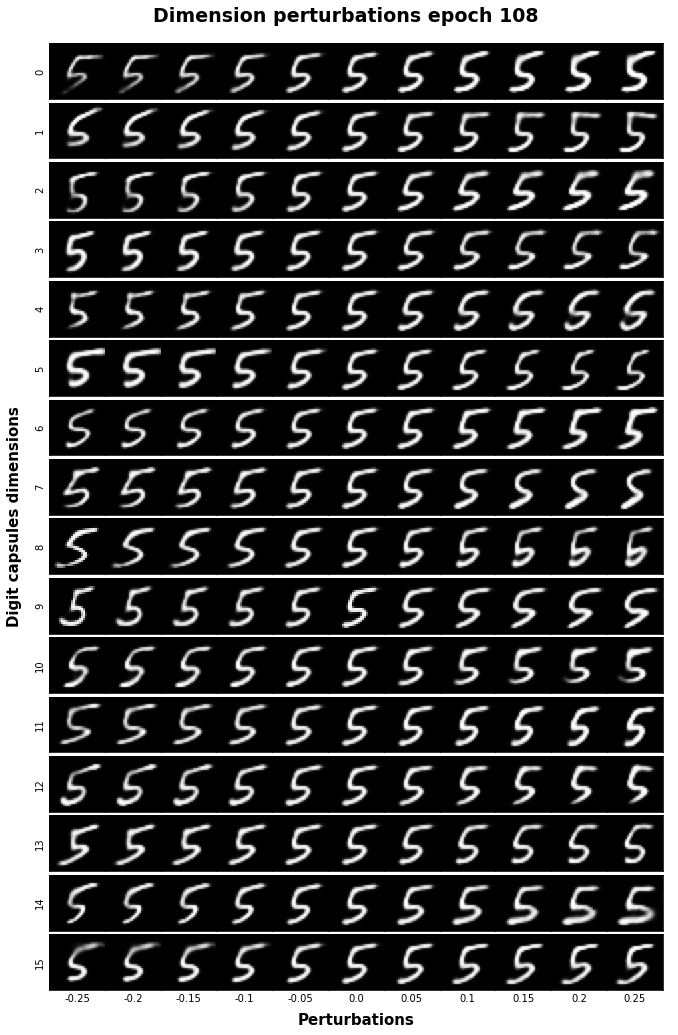

In [128]:
# Show what the individual dimensions of a capsule represent
class_caps_shape = class_caps_poses.size(-2), class_caps_poses.size(-1)
index = 3
example_caps = class_caps_poses[index].unsqueeze(0) # example_caps: [1, 10, 16]
label_caps = target[index] # label_caps: [1, 10]
activations = class_caps_activations[index, :].view(-1, config.num_classes)
perturb_range = np.linspace(start=-0.25, stop=0.25, num=11)

nrow = class_caps_shape[0] * class_caps_shape[1]
ncol = perturb_range.size

fig = plt.figure(figsize=(ncol, nrow))

gs = gridspec.GridSpec(nrow, ncol, width_ratios=np.ones(ncol),hspace=0,wspace=0)
perturb_reconstructions_stacked = torch.stack(perturb_reconstructions, dim=0)
perturb_reconstructions_stacked = perturb_reconstructions_stacked.view(nrow, ncol, perturb_reconstructions_stacked.size(1),  perturb_reconstructions_stacked.size(2))
for i in range(nrow):
    for j in range(ncol):
        perturb = perturb_range[j]
        ax = plt.subplot(gs[i, j])
        example_caps_perturbed = example_caps.clone()
        example_caps_perturbed[:, :, i] += perturb
        perturb_rec = model.decoder(example_caps_perturbed, activations)
        perturb_rec = perturb_rec.view(images.size(1), images.size(2), images.size(3))
        np_perturb_rec = perturb_rec.squeeze().cpu().detach().numpy()

        ax.imshow(np_perturb_rec, cmap=config.cmap)
        ax.set_yticks([])
        ax.set_xticks([])
        ax.set_ylabel(i)
        ax.set_xlabel(round(perturb_range[j], 3))
        ax.set_aspect('equal')

gs.update(wspace=0.0, hspace=0.0) # set the spacing between axes.
fig.subplots_adjust(top=0.95) 
fig.add_subplot(1, 1, 1, frame_on=False)
# Hiding the axis ticks and tick labels of the bigger plot
plt.tick_params(labelcolor="none", bottom=False, left=False)
fig.suptitle("Dimension perturbations epoch " + config.epoch, fontsize=19, fontweight='bold') 
plt.xlabel('Perturbations', fontsize=15, fontweight='bold')
plt.ylabel('Digit capsules dimensions', fontsize=15, fontweight='bold')
plt.show()